
# CineFeel_Phase_1.Object_detection
 이 노트북은 영상에서 얼굴을 탐지하고 Deepface 분석을 위한 데이터를 준비합니다.
- 얼굴 탐지는 Mediapipe 솔루션의 얼굴 감지 클래스를 이용합니다.
  - model_selection=1: 전체화면(또는 원거리용) 모델 사용
  - min_detection_confidence=0.5 : 신뢰도 0.5 이상만 사용


- 상세한 설명은 [공식 링크](https://ai.google.dev/edge/mediapipe/solutions/vision/face_detector?hl=ko#blazeface_full-range)

In [ ]:
import os
import sys
from pathlib import Path

print("🎯 CineFeel Object Detection Pipeline")
print("=" * 50)

🎯 CineFeel Object Detection Pipeline


# 객체 탐지 환경 설치

In [ ]:
# prompt: 필요한 라이브러리 opencv-python, mediapipe, numpy, tqdm 설치

!pip install opencv-python mediapipe numpy tqdm

INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colabsqlviz 0.1.3 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.73.1 requires protobuf<7.0.0,>=6.30.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp

print("설치 후 버전 확인:")
print(f"OpenCV version: {cv2.__version__}")
print(f"Mediapipe version: {mp.__version__}")

설치 후 버전 확인:
OpenCV version: 4.12.0
Mediapipe version: 0.10.14


# 시스템 정보 확인

In [ ]:
import torch
import platform

print("��️ 시스템 정보:")
print(f"  OS: {platform.system()} {platform.release()}")
print(f"  Python: {platform.python_version()}")
print(f"  GPU 사용 가능: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  GPU 모델: {torch.cuda.get_device_name(0)}")
    print(f"  GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")
    print(f"  GPU 개수: {torch.cuda.device_count()}")
else:
    print("  ⚠️ GPU를 사용할 수 없습니다. CPU로 실행됩니다.")

print("\n💾 메모리 정보:")
import psutil
print(f"  총 메모리: {psutil.virtual_memory().total / 1e9:.1f}GB")
print(f"  사용 가능: {psutil.virtual_memory().available / 1e9:.1f}GB")

��️ 시스템 정보:
  OS: Linux 6.1.143+
  Python: 3.11.13
  GPU 사용 가능: True
  GPU 모델: NVIDIA L4
  GPU 메모리: 23.7GB
  GPU 개수: 1

💾 메모리 정보:
  총 메모리: 16.8GB
  사용 가능: 14.8GB


# 파이프라인 설정

이 셀의 변수들을 수정하여 파이프라인을 설정하세요. 모든 경로는 이 셀에서 관리됩니다.

In [ ]:
# ===============================================================
# 🔧 CONFIGURATION - 이 셀의 변수들을 수정하여 파이프라인을 설정하세요.
# ===============================================================

# --- 1. Google Cloud 설정 ---
PROJECT_ID = 'sesac-ljj0210'
GCS_BUCKET_NAME = 'sesac-ljj-20250715'
GCS_PROJECT_PATH = 'pjt_cinefeel'

# --- 2. 입력 데이터 경로 ---
# 원본 비디오가 저장된 GCS 경로
# GCS_SOURCE_VIDEO_PATH = f"gs://{GCS_BUCKET_NAME}/{GCS_PROJECT_PATH}/src/source_collector/result/video/0001_tmdb_video_01.mp4"
GCS_SOURCE_VIDEO_PATH = ''
# 비디오를 다운로드할 로컬 임시 경로
LOCAL_VIDEO_PATH = "/tmp/"

# --- 3. 모델 및 처리 설정 ---
# 얼굴 탐지에 사용할 ArcFace 모델 최적화 설정
ARCFACE_CONFIG = {
    'blur_threshold': 30.0,
    'min_face_size_pixels': 100
}
# 처리할 비디오의 프레임 간격 (초)
FRAME_INTERVAL_SECONDS = 1

# --- 4. 출력 데이터 경로 ---
# 얼굴 이미지가 저장될 로컬 디렉토리
LOCAL_RESULT_DIR = "/content/cinefeel_practice-main/src/object_detection/result/video"
# 압축된 결과 파일을 업로드할 GCS 경로
GCS_RESULT_BUCKET_PATH = f"gs://{GCS_BUCKET_NAME}/{GCS_PROJECT_PATH}/src/object_detection/result/"

print("✅ Configuration Loaded")
print(f"PROJECT_ID: {PROJECT_ID}")
print(f"GCS_SOURCE_VIDEO_PATH: {GCS_SOURCE_VIDEO_PATH}")
print(f"LOCAL_RESULT_DIR: {LOCAL_RESULT_DIR}")
print(f"GCS_RESULT_BUCKET_PATH: {GCS_RESULT_BUCKET_PATH}")

✅ Configuration Loaded
PROJECT_ID: sesac-ljj0210
GCS_SOURCE_VIDEO_PATH: 
LOCAL_RESULT_DIR: /content/cinefeel_practice-main/src/object_detection/result/video
GCS_RESULT_BUCKET_PATH: gs://sesac-ljj-20250715/pjt_cinefeel/src/object_detection/result/


# 데이터 준비
영화 데이터를 준비하거나 기존 데이터를 확인합니다

In [ ]:
# prompt: 구글 드라이브 링크 https://drive.google.com/file/d/1wJ-TS4uwkxYoCq0AjUnrUea5GN6voC58/view?usp=drive_link 이런 링크의 zip파일 가져와 unzip

import os
import zipfile
import gdown

# Google Drive 링크에서 파일 ID 추출
file_id = '1wJ-TS4uwkxYoCq0AjUnrUea5GN6voC58'

# 파일 다운로드
output_zip_path = os.path.join(LOCAL_VIDEO_PATH, 'downloaded.zip') # LOCAL_VIDEO_PATH 사용
gdown.download(id=file_id, output=output_zip_path, quiet=False)


# 압축 해제
extract_dir = os.path.join(LOCAL_VIDEO_PATH, 'extracted') # LOCAL_VIDEO_PATH 사용
with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Downloaded and extracted to {extract_dir}")

# 다운로드한 파일 경로 GCS_SOURCE_VIDEO_PATH 에 할당.
# 압축 해제 후, 실제 비디오 파일 경로를 확인하고 GCS_SOURCE_VIDEO_PATH에 정확한 경로를 지정해야 합니다.
# 예시: 압축 해제된 파일이 'extracted/video.mp4' 라면
# GCS_SOURCE_VIDEO_PATH = os.path.join(extract_dir, 'video.mp4')
# 아래는 예시이며, 실제 파일 구조에 맞춰 수정해야 합니다.
GCS_SOURCE_VIDEO_PATH = os.path.join(extract_dir, '*.mp4') # 모든 mp4 파일을 처리하려는 경우

print(f"✅ Video path updated: {GCS_SOURCE_VIDEO_PATH}")

Downloading...
From (original): https://drive.google.com/uc?id=1wJ-TS4uwkxYoCq0AjUnrUea5GN6voC58
From (redirected): https://drive.google.com/uc?id=1wJ-TS4uwkxYoCq0AjUnrUea5GN6voC58&confirm=t&uuid=79c4577d-8242-47e5-8634-1c39dd138386
To: /tmp/downloaded.zip
100%|██████████| 636M/636M [00:05<00:00, 108MB/s]


✅ Downloaded and extracted to /tmp/extracted
✅ Video path updated: /tmp/extracted/*.mp4


In [ ]:
# prompt: 상수를 이용해 gcp 버킷 연결

from google.colab import auth
auth.authenticate_user()

!gcloud config set project {PROJECT_ID}

# Download the source video from GCS
!gsutil cp {GCS_SOURCE_VIDEO_PATH} {LOCAL_VIDEO_PATH}

# Create the local result directory if it doesn't exist
!mkdir -p {LOCAL_RESULT_DIR}

Updated property [core/project].
Copying file:///tmp/extracted/doklipmovie_1440p_fixed.mp4...
Copying file:///tmp/extracted/doklipmovie_360p_fixed.mp4...
Copying file:///tmp/extracted/doklipmovie_720p_fixed.mp4...
/ [3 files][609.6 MiB/609.6 MiB]                                                
Operation completed over 3 objects/609.6 MiB.                                    


In [ ]:
# prompt: LOCAL_VIDEO_PATH 의 첫번째 영상파일을 LOCAL_VIDEO_PATH 로 지정

import glob

# LOCAL_VIDEO_PATH에 있는 모든 .mp4 파일을 찾습니다.
video_files = glob.glob(os.path.join(LOCAL_VIDEO_PATH, "*.mp4"))

# 파일이 있는지 확인하고 첫 번째 파일을 GCS_SOURCE_VIDEO_PATH에 할당합니다.
if video_files:
    GCS_SOURCE_VIDEO_PATH = video_files[2]
    print(f"✅ First video file found: {GCS_SOURCE_VIDEO_PATH}")
else:
    print(f"⚠️ No video files found in {LOCAL_VIDEO_PATH}")

✅ First video file found: /tmp/doklipmovie_720p_fixed.mp4


In [ ]:
# prompt: 버킷에서 다운로드 받은 비디오 정보 확인, 길이, 총프레임수, 해상도 등

import cv2

def get_video_info(video_path):
  """
  비디오 정보를 가져오는 함수.

  Args:
    video_path: 비디오 파일 경로.

  Returns:
    dict: 비디오 정보를 담은 딕셔너리.
  """
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      raise IOError(f"비디오 파일을 열 수 없습니다: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps

    cap.release()
    return {
        "fps": fps,
        "frame_count": frame_count,
        "width": width,
        "height": height,
        "duration": duration,
    }
  except Exception as e:
    print(f"Error: {e}")
    return None


video_info = get_video_info(GCS_SOURCE_VIDEO_PATH)

if video_info:
  print("🎬 비디오 정보:")
  for key, value in video_info.items():
    print(f"  {key}: {value}")

🎬 비디오 정보:
  fps: 23.976035734533376
  frame_count: 48888
  width: 2560
  height: 1440
  duration: 2039.036


# 🎯 객체 탐지 실행

영상에서 얼굴을 탐지하고 Deepface 분석용 데이터를 생성합니다

In [ ]:
# prompt: 결과 생성 디렉토리 비우기

!rm -rf {LOCAL_RESULT_DIR}/*

In [ ]:
# 얼굴 탐지기 초기화
try:
    face_detector = mp.solutions.face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=0.5
    )
except Exception as e:
    print(f"❌ MediaPipe 얼굴 탐지기 초기화 실패: {e}")


print(face_detector)


import cv2
import mediapipe as mp

face_detector = mp.solutions.face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.5
)

# 이미지 로드 (GCS_SOURCE_VIDEO_PATH에서 프레임을 읽어오는 방식으로 변경)
cap = cv2.VideoCapture(GCS_SOURCE_VIDEO_PATH)
ret, frame = cap.read()
if not ret:
    print("프레임을 읽을 수 없습니다.")
else:
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detector.process(image)

    if results.detections:
        for detection in results.detections:
            print(detection)
            # detection 객체의 속성들을 출력하여 자세한 정보 확인
            print(f"  Bounding Box: {detection.location_data.relative_bounding_box}")
            print(f"  Keypoints: {detection.location_data.relative_keypoints}")
            print(f"  Scores: {detection.scores}")

    cap.release()



In [ ]:
# prompt: <mediapipe.python.solutions.face_detection.FaceDetection object at 0x7fc233fb5350> 구조 확인

# Mediapipe Face Detection 모델의 구조를 확인하기 위해 다음과 같은 방법을 사용할 수 있습니다.

# 1. print(face_detector) 를 사용하여 객체 정보 출력:
# 이 방법은 FaceDetection 객체의 기본 정보를 출력합니다.  내부 구조에 대한 자세한 정보는 제공하지 않습니다.
print(face_detector)

# 2. FaceDetection 객체의 속성 확인:
# FaceDetection 객체는 다양한 속성을 가지고 있습니다. 이러한 속성을 확인하여 모델의 설정 및 기능에 대한 정보를 얻을 수 있습니다.
# 예시:
print(dir(face_detector)) # 객체의 속성 및 메서드 목록 출력



['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_packet_content', '_graph', '_graph_outputs', '_initialize_graph_interface', '_input_side_packets', '_input_stream_type_info', '_make_packet', '_modify_calculator_options', '_output_stream_type_info', '_set_extension', '_side_input_type_info', '_simulated_timestamp', 'close', 'create_graph_options', 'process', 'reset']


In [ ]:
import cv2
import mediapipe as mp
from pathlib import Path
from tqdm import tqdm
import traceback

def process_video_and_save_faces(video_path, output_dir, config, interval_seconds):
    """비디오를 프레임 단위로 처리하여, 탐지된 얼굴을 즉시 파일로 저장합니다."""
    print(f"🎬 비디오 처리 및 저장 시작: {Path(video_path).name}")

    # 얼굴 탐지기 초기화
    try:
        face_detector = mp.solutions.face_detection.FaceDetection(
            model_selection=1, min_detection_confidence=0.5
        )
    except Exception as e:
        print(f"❌ MediaPipe 얼굴 탐지기 초기화 실패: {e}")
        return False

    # 비디오 캡처 객체 열기
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ 비디오 파일을 열 수 없습니다: {video_path}")
        return False

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # 설정된 초 간격에 따라 프레임 간격 계산
    frame_interval = int(fps * interval_seconds) if fps > 0 else 1

    # 출력 디렉토리 생성
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    saved_face_count = 0
    frame_num = 0

    with tqdm(total=(total_frames // frame_interval if frame_interval > 0 else total_frames), desc="이미지 처리 및 저장") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # 설정된 간격의 프레임만 처리
            if frame_num % frame_interval == 0:
                try:
                    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    detections = face_detector.process(image_rgb).detections

                    if detections:
                        frame_height, frame_width, _ = frame.shape
                        for i, detection in enumerate(detections):
                            bboxC = detection.location_data.relative_bounding_box
                            bbox = {
                                "x": int(bboxC.xmin * frame_width),
                                "y": int(bboxC.ymin * frame_height),
                                "width": int(bboxC.width * frame_width),
                                "height": int(bboxC.height * frame_height)
                            }

                            min_face_ratio = 0.05  # 화면의 5% 이상

                            if bbox['width'] < frame_width * min_face_ratio or bbox['height'] < frame_height * min_face_ratio:
                                continue


                            face_crop = frame[bbox['y']:bbox['y']+bbox['height'], bbox['x']:bbox['x']+bbox['width']]
                            if face_crop.size == 0:
                                continue

                            # 설정 값에 따라 블러 필터링
                            gray_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
                            blur_value = cv2.Laplacian(gray_crop, cv2.CV_64F).var()
                            if blur_value < config['blur_threshold']:
                                continue

                            # 탐지된 얼굴을 즉시 파일로 저장
                            filename = f'frame{frame_num}_face{i}.jpg'
                            filepath = Path(output_dir) / filename
                            cv2.imwrite(str(filepath), face_crop)
                            saved_face_count += 1
                except Exception as e:
                    print(f"⚠️ 프레임 {frame_num} 처리 중 오류: {e}")
                pbar.update(1)

            frame_num += 1

    cap.release()
    if saved_face_count > 0:
        print(f"\n✅ 처리 완료: 총 {saved_face_count}개의 얼굴 이미지를 '{output_dir}'에 저장했습니다.")
        return True
    else:
        print("\n🟡 처리는 완료되었으나, 설정에 맞는 얼굴을 찾지 못했습니다.")
        # 얼굴이 없더라도 후속 단계(업로드)가 실패로 간주되지 않도록 True를 반환할 수 있으나,
        # 여기서는 실제 저장된 파일이 있는지 여부로 판단하기 위해 False를 반환합니다.
        return False

# --- 실행 ---
# 설정 변수를 사용하여 비디오 처리 및 저장 실행
save_success = process_video_and_save_faces(
    video_path=GCS_SOURCE_VIDEO_PATH,
    output_dir=LOCAL_RESULT_DIR,
    config=ARCFACE_CONFIG,
    interval_seconds=FRAME_INTERVAL_SECONDS
)

🎬 비디오 처리 및 저장 시작: doklipmovie_720p_fixed.mp4


이미지 처리 및 저장: 2126it [06:21,  5.57it/s]



✅ 처리 완료: 총 652개의 얼굴 이미지를 '/content/cinefeel_practice-main/src/object_detection/result/video'에 저장했습니다.


# 결과 버킷에 저장

In [ ]:
import os
import zipfile
import datetime
import subprocess

def zip_and_upload_results(source_dir, gcs_bucket_path):
    print("☁️ 결과를 ZIP 파일로 압축하여 GCS 버킷에 업로드:")

    # 'save_success' 플래그를 확인하여 이전 단계의 성공 여부를 판단합니다.
    if not 'save_success' in globals() or not save_success:
        print("🟡 저장된 결과가 없어 업로드를 건너뜁니다.")
        return

    # 소스 디렉토리 존재 및 파일 유무 재확인
    if not os.path.isdir(source_dir) or not os.listdir(source_dir):
        print(f"❌ 압축할 파일이 '{source_dir}'에 없습니다.")
        return

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_filename = f"Arcface_{timestamp}.zip"
    local_zip_path = f"/tmp/{zip_filename}"

    print(f"압축 시작... -> '{local_zip_path}'")
    try:
        with zipfile.ZipFile(local_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for file in os.listdir(source_dir):
                zipf.write(os.path.join(source_dir, file), arcname=file)
        print(f"✅ 총 {len(os.listdir(source_dir))}개의 파일을 성공적으로 압축했습니다.")

    except Exception as e:
        print(f"❌ ZIP 파일 생성 중 오류 발생: {e}")
        return

    full_gcs_path = os.path.join(gcs_bucket_path, zip_filename)
    print(f"'{local_zip_path}' 파일을 '{full_gcs_path}'(으)로 업로드합니다...")

    command = f"gsutil cp \"{local_zip_path}\" \"{full_gcs_path}\""

    try:
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
        print("\n✅ ZIP 파일 업로드 완료!")
    except subprocess.CalledProcessError as e:
        print("❌ 업로드 실패:")
        print(e.stderr)

# 업로드 함수 실행
zip_and_upload_results(LOCAL_RESULT_DIR, GCS_RESULT_BUCKET_PATH)

☁️ 결과를 ZIP 파일로 압축하여 GCS 버킷에 업로드:
압축 시작... -> '/tmp/Arcface_20250805_060038.zip'
✅ 총 661개의 파일을 성공적으로 압축했습니다.
'/tmp/Arcface_20250805_060038.zip' 파일을 'gs://sesac-ljj-20250715/pjt_cinefeel/src/object_detection/result/Arcface_20250805_060038.zip'(으)로 업로드합니다...

✅ ZIP 파일 업로드 완료!


# 📊 객체 탐지 결과 확인

✅ 데이터셋을 '/content/cinefeel_practice-main/src/object_detection/dataset'에 저장했습니다.


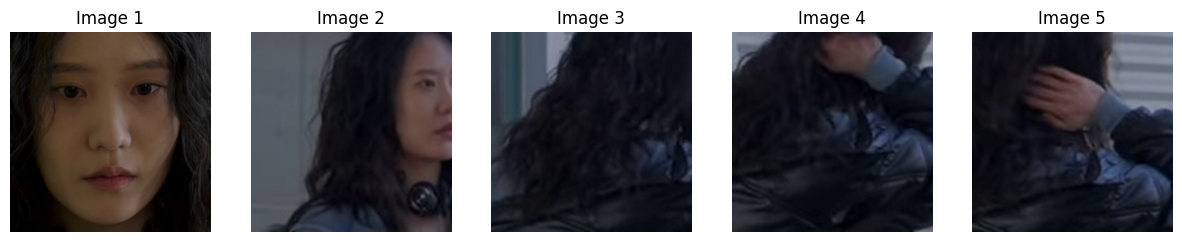

다음 모델에 사용할 이미지 배열 형태 (shape: (661, 224, 224, 3)):


In [ ]:
# prompt: 저장된 이미지들을 다음 모델에 넣을 데이터셋 형태로 만들고 예시 파일들을 확인하고 싶어

import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 저장된 이미지들을 배열로 로드하고 크기 조정 ---
def load_and_resize_images(image_dir, target_size=(224, 224)):
    """
    주어진 디렉토리에서 이미지를 로드하고 크기를 조정합니다.

    Args:
        image_dir: 이미지가 있는 디렉토리 경로.
        target_size: 목표 이미지 크기 (튜플).

    Returns:
        Numpy 배열: 크기가 조정된 이미지 배열. 이미지가 없으면 None을 반환합니다.
    """
    image_files = sorted([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if not image_files:
        print("⚠️ 이미지 파일을 찾을 수 없습니다.")
        return None

    images = []
    for filename in image_files:
        filepath = os.path.join(image_dir, filename)
        try:
            img = Image.open(filepath).convert('RGB')  # RGB 모드로 변환
            img = img.resize(target_size)
            images.append(np.array(img))
        except Exception as e:
            print(f"❌ 이미지 로드 실패: {filename}, 오류: {e}")

    return np.array(images)


resized_images = load_and_resize_images(LOCAL_RESULT_DIR)

if resized_images is not None:
    # --- 2. 데이터셋 형태로 저장 (선택적) ---
    dataset_dir = "/content/cinefeel_practice-main/src/object_detection/dataset"
    os.makedirs(dataset_dir, exist_ok=True)
    for i, img in enumerate(resized_images):
        Image.fromarray(img).save(os.path.join(dataset_dir, f"image_{i:04d}.jpg"))
    print(f"✅ 데이터셋을 '{dataset_dir}'에 저장했습니다.")

    # --- 3. 샘플 이미지 확인 ---
    num_samples_to_display = min(5, len(resized_images))  # 최대 5개 이미지 표시
    plt.figure(figsize=(15, 5))
    for i in range(num_samples_to_display):
        plt.subplot(1, num_samples_to_display, i + 1)
        plt.imshow(resized_images[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()


# --- 4. 다음 모델에 사용할 수 있도록 배열 형태로 반환 ---
if resized_images is not None:
    print(f"다음 모델에 사용할 이미지 배열 형태 (shape: {resized_images.shape}):")
    # resized_images 배열을 다음 모델에 전달